# **I. Preparation**

## A. Imports

In [83]:
from google.colab import drive
drive.mount('/content/drive')

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statistics as stat
import sys

from importlib import reload

from scipy.stats import uniform

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from xgboost import plot_importance

# Constants
PATH = '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P7 Modèle de scoring/'

os.chdir(PATH)
if PATH not in sys.path:
    sys.path.append(PATH)

import std_eda
import std_q7
import std_piechart
import std_pareto
import std_histogram
reload(std_eda)
reload(std_q7)
reload(std_piechart)
reload(std_pareto)
reload(std_histogram)

# Options
sns.set_theme(style="darkgrid")
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## B. Uploads

In [84]:
train_df = pd.read_csv(PATH + 'data/app_train.csv', sep=',')
test_df = pd.read_csv(PATH + 'data/app_test.csv', sep=',')

## C. Inputs check

In [85]:
train_df.shape

(307508, 306)

In [86]:
test_df.shape

(48744, 305)

In [87]:
train_df.drop('SK_ID_CURR', axis=1, inplace=True)
test_df.drop('SK_ID_CURR', axis=1, inplace=True)

([<matplotlib.patches.Wedge at 0x7f9db86c0c90>,
 [Text(-0.45840470672487627, -0.9999325601521737, 'Train set'),
  Text(0.4584047067248764, 0.9999325601521736, 'Test_set')],
 [Text(-0.25003893094084156, -0.5454177600830038, '86.3'),
  Text(0.2500389309408416, 0.5454177600830037, '13.7')])

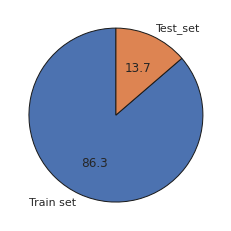

In [88]:
plt.pie(x=[train_df.shape[0], test_df.shape[0]],
        labels=['Train set', 'Test_set'],
        autopct=lambda x: round(x, 1),
        startangle=90,
        wedgeprops={'edgecolor':'k', 'linewidth': 1})

# **II. Modelisation**

## Settings

In [89]:
# Activate or deactivate long computations
long_computation = True
# Take a sample of the original dataframes
train_samp_df = train_df.sample(frac=0.02, random_state=1)
test_samp_df = test_df.sample(frac=0.02, random_state=1)
# Set train and validation set 
X = train_samp_df.drop('TARGET', axis=1)
targets = train_samp_df['TARGET']
# Ratio train/test
train_size = train_df.shape[0]
test_size = test_df.shape[0]
ratio_train_test = test_size / train_size
# Split the set
# The smallest part will be used to choose the best algorithm.
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    targets,
    test_size=0.2,
    random_state=1)
# Split the set
# The smallest part will be used to determine the best hyperparameters.
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.2,
    random_state=1)
# Save the scores in a dataframe
scores_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall',
                                  'f1-score', 'Average precision', 'FP cost',
                                  'FN cost', 'Total cost'],
                         index=['Dummy', 'Decision tree',
                                'Logistic regression', 'SVC', 
                                'Random forest'])

## Fonctions

In [90]:
def class_model_perf(X, targets, model):
    '''
    Designed for a binary classification, two categories in total.
    Important: the model must be already instantiated.
    '''
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      targets,
                                                      test_size=0.2,
                                                      random_state=1)
    # Fit the model
    model.fit(X_train, y_train)

    # Accuracy
    accuracy = round(model.score(X_val, y_val), 3)
    
    # Confusion matrix elements
    y_pred = model.predict(X_val)
    # Get the false predictions
    pred_dict = dict(pd.Series(y_val - y_pred).value_counts())
    if -1.0 in pred_dict.keys():
        n_FP = pred_dict[-1.0]
    else:
        n_FP = 0
    if 1.0 in pred_dict.keys():
        n_FN = pred_dict[1.0]
    else:
        n_FN = 0
    # Get the true predictions
    temp_dict = dict(pd.Series(2 * y_val - y_pred).value_counts())
    if 1.0 in temp_dict.keys():
        n_TP = temp_dict[1.0]
    else:
        n_TP = 0
    
    try:
        # Precision
        precision = round(n_TP / (n_TP + n_FP), 4)

        # Recall
        recall = round(n_TP / (n_TP + n_FN), 4)
    except ZeroDivisionError:
        return 'n_FP: {}, n_FN: {}, n_TP: {}.'.format(n_FP, n_FN, n_TP)

    # f1 score
    f1 = round(f1_score(y_val, y_pred), 4)

    return 'Accuracy: {}, Precision: {}, Recall: {}, f1-score: {}'.format(
        accuracy, precision, recall, f1)


def list_sample(my_list, chunk):
    '''
    Let a list be given, we select every 'chunk' element.
    Return a list of the selected elements.
    '''
    y = zip(*[iter(my_list)]*chunk)
    return [element[0] for element in y]


def plot_precision_recall_curve(model, X, targets, chunk=1):
    '''

    '''
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      targets,
                                                      test_size=0.2,
                                                      random_state=1)
    # Fit the model
    model.fit(X_train, y_train)
    
    precision, recall, threshold = precision_recall_curve(
        y_val,
        model.predict_proba(X_val)[:, 1])
    f1_score = 2 * precision * recall / (precision + recall)
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    f1_score = list_sample(f1_score, chunk)
    f1_score = np.array(f1_score)
    max_f1 = round(max(f1_score), 3)

    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    close_default = np.argmin(np.abs(threshold - 0.5))
    plt.scatter(precision,
                recall,
                s=f1_score*2000,
                c=f1_score,
                cmap='Reds_r',
                edgecolors='k',
                alpha=0.5,
                label='Max f1_score: {}'.format(max_f1))
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # ADDITIONAL curves
    x = list(range(0, 100))
    x = [element/100 for element in x]
    # Line of equation y = x
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


def prediction_costs(model, X_val, y_val, y_pred=None):
    '''
    Return the sum of: 
    - the cost of false positives,
    - the cost of false negatives.
    '''
    # Add the prediction errors to the original dataframe
    if y_pred==None:
        y_pred = model.predict(X_val)
    X_val['Prediction error'] = y_val - y_pred
    # Create a new feature, multiplying the difference by a money feature.
    # This will be choosen based on feature importances.
    # FP costs
    # log_AMT_ANNUITY_prev: Annuity of previous application
    # AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit.
    # Although useful, it is absent of test set, thus cannot be used. 
    FP_list = []
    for i, row in enumerate(X_val):
        if X_val['Prediction error'].iloc[i] == -1:
            FP_list.append(-X_val['Prediction error'].iloc[i] *
                           X_val['log_AMT_ANNUITY_prev'].iloc[i])
    FP_sum = sum(FP_list)
    # FN costs
    # log_AMT_ANNUITY: Loan annuity
    FN_list = []
    for i, row in enumerate(X_val):
        if X_val['Prediction error'].iloc[i] == 1:
            FN_list.append(X_val['Prediction error'].iloc[i] *
                           X_val['log_AMT_ANNUITY'].iloc[i])
    FN_sum = sum(FN_list)
    
    return FP_sum + FN_sum


def prediction_costs_for_cv(y, y_pred):
    '''
    Designed to be used in a cross validation as a specific scorer.
    Return the sum of: 
    - the cost of false positives,
    - the cost of false negatives.
    '''
    # Add the prediction errors to the original dataframe
    X_val['Prediction error'] = y - y_pred
    # Create a new feature, multiplying the difference by a money feature.
    # This will be choosen based on feature importances.
    # FP costs
    # log_AMT_ANNUITY_prev: Annuity of previous application
    # AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit
    FP_list = []
    for i, row in enumerate(X_val):
        if X_val['Prediction error'].iloc[i] == -1:
            FP_list.append(-X_val['Prediction error'].iloc[i] *
                           X_val['log_AMT_ANNUITY_prev'].iloc[i])
    FP_sum = sum(FP_list)
    # FN costs
    # log_AMT_ANNUITY: Loan annuity
    FN_list = []
    for i, row in enumerate(X_val):
        if X_val['Prediction error'].iloc[i] == 1:
            FN_list.append(X_val['Prediction error'].iloc[i] *
                           X_val['log_AMT_ANNUITY'].iloc[i])
    FN_sum = sum(FN_list)
    X_val.drop('Prediction error', axis=1, inplace=True)
    return FP_sum + FN_sum


def costs_estimation(model, X, targets, chunk=1):
    '''

    '''
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      targets,
                                                      test_size=0.2,
                                                      random_state=1)
    # Fit the model
    model.fit(X_train, y_train)
    # Prepare for y_pred computation
    pred_proba = model.predict_proba(X_val)
    predict = [element[1] for element in pred_proba]
    precision, recall, thresholds = precision_recall_curve(
        y_val,
        model.predict_proba(X_val)[:, 1])
    
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    thresholds = list_sample(thresholds, chunk)
    thresholds = np.array(thresholds)

    #thresh_list = [element / 100 for element in list(range(0, 100))]
    # Evaluate costs for different values of threshold
    y_costs = []
    for threshold in list(thresholds):
        # Compute y_pred
        y_pred = []
        for element in predict:
            if element >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        # Compute the costs
        y_costs.append(prediction_costs(model,
                                        X_val,
                                        y_val,
                                        y_pred))

    # Set the 3 lists at the same size
    precision = list(precision)
    recall = list(recall)
    temp_min = min(len(precision), len(recall), len(y_costs))
    precision = precision[:temp_min]
    recall = recall[:temp_min]
    y_costs = y_costs[:temp_min]
    return precision, recall, y_costs, thresholds


def costs_curve(model, X, targets, chunk=1):
    '''
    Display the precision / recall curve, the size and color of each point
    representing its corresponding cost.
    '''
    # get the 
    precision, recall, y_costs, thresholds = costs_estimation(model,
                                                              X,
                                                              targets,
                                                              chunk=chunk)
    # Plot the graph
    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    close_default = np.argmin(np.abs(thresholds - 0.5))
    plt.scatter(precision,
                recall,
                s=[element * 5 for element in y_costs],
                c=y_costs,
                cmap='Reds',
                edgecolors='k',
                alpha=0.5)
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # ADDITIONAL curves
    x = list(range(0, 100))
    x = [element/100 for element in x]
    # Line of equation y = x
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


def plot_ROC_curve(model, X, targets):
    '''

    '''
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      targets,
                                                      test_size=0.2,
                                                      random_state=1)
    # Fit the model
    model.fit(X_train, y_train)
    fpr, tpr, threshold = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR (recall)')
    plt.title('ROC curve')
    plt.plot(fpr, tpr)


def lowest_costs_param(model, X, targets):
    '''
    Return the lowest cost obtained.
    '''
    precision, recall, costs, thresholds = costs_estimation(model, X, targets)
    precision = [round(element, 2) for element in precision]
    recall = [round(element, 2) for element in recall]
    thresholds = [round(element, 3) for element in thresholds]
    costs = [round(element, 3) for element in costs]
    df = pd.DataFrame({'Precision':precision,
                    'Recall':recall,
                    'Cost':costs,
                    'Threshold':thresholds})
    df.sort_values(by='Cost', inplace=True)
    return dict(df.iloc[0])


def plot_feature_importances(model, X, n_feat):
    '''
    Display a histogram of the feature importances, sorted from the most
    important to the least important.
    '''
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    plt.bar(range(len(feature_importances)),
            feature_importances,
            edgecolor='k')


def feature_importance_cumsum(model, df, filter=None):
    '''

    '''
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    forest_importances = pd.Series(importances,
                                   index=X.columns)
    forest_importances.sort_values(ascending=False,
                                   inplace=True)
    if filter:
        # Sort and filter the first 10% 
        ratio = len(forest_importances)//10
        forest_importances = forest_importances[:ratio]
        forest_importances
    plt.plot(forest_importances.cumsum())


def most_important_features(model, X, n_feat=6):
    '''
    Display the n most important feature.
    '''
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    return feature_importances


def plot_important_features(feature_importances):
    '''
    
    '''
    plt.barh(feature_importances.index,
             feature_importances)

## A. Dummy classifier

In [91]:
# Instanciation
model = DummyClassifier(strategy='constant', constant=1)
# Scores
class_model_perf(X, targets, model)

'Accuracy: 0.078, Precision: 0.078, Recall: 1.0, f1-score: 0.1448'

## B. Decision tree

In [92]:
# Instanciation
model = DecisionTreeClassifier(max_depth=2)
# Evaluation
class_model_perf(X, targets, model)

'Accuracy: 0.92, Precision: 0.25, Recall: 0.0104, f1-score: 0.02'

## C. Logistic regression

In [93]:
# Accuracy score
model = LogisticRegression(C=0.1)
# Evaluation
class_model_perf(X, targets, model)

'n_FP: 0, n_FN: 96, n_TP: 0.'

## D. SVC

In [94]:
if False:
    # Instanciation
    model = SVC(gamma=0.05)
    # Evaluation
    class_model_perf(X, targets, model)

## E. Random forest

In [95]:
amt_of_0 = dict(targets.value_counts())[0]
amt_of_1 = dict(targets.value_counts())[1]
ratio = amt_of_1 / amt_of_0
# Instanciation
model = RandomForestClassifier(n_estimators=100,
                               random_state=0,
                               max_features=2,
                               class_weight={0:ratio, 1:1})
# Evaluation
class_model_perf(X, targets, model)

'n_FP: 0, n_FN: 96, n_TP: 0.'

In [96]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


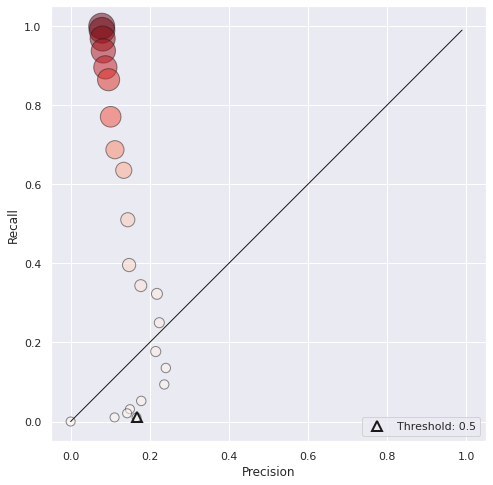

In [97]:
# Costs curve
if True:
    costs_curve(model, X, targets)

In [98]:
# Lowest cost
lowest_costs_param(model, X, targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Cost': 15.886, 'Precision': 0.17, 'Recall': 0.01, 'Threshold': 0.22}

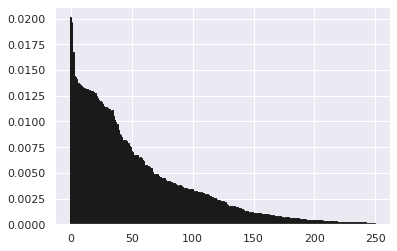

In [99]:
# Feature importances
if True:
    plot_feature_importances(model, X, 250)

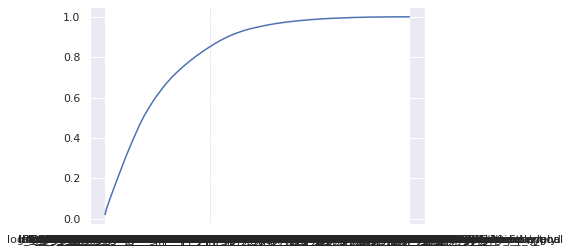

In [100]:
# Feature importances: cumulated sum
if True:
    feature_importance_cumsum(model, X)

In [101]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

In [102]:
# ROC curve
if False:
    plot_ROC_curve(model, X, targets)

In [103]:
# Average precision


## F. GradientBoosting

In [104]:
if True:
    # Instanciation
    model = GradientBoostingClassifier()
    # Evaluation
    class_model_perf(X, targets, model)

In [105]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


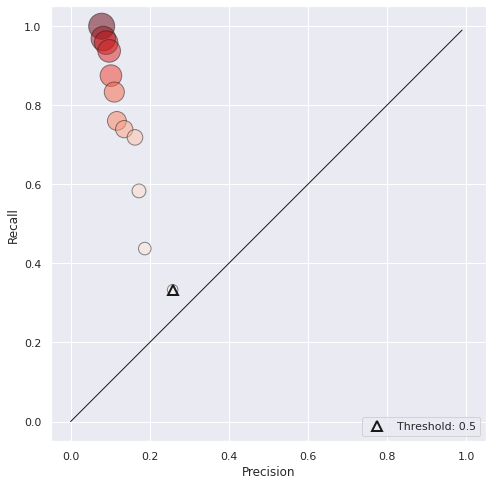

In [106]:
# Costs curve
if True:
    costs_curve(model, X, targets, chunk=100)

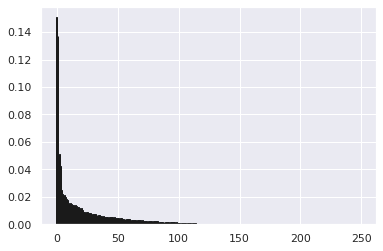

In [107]:
# Feature importances
if True:
    plot_feature_importances(model, X, 250)

In [108]:
# Feature importances: cumulated sum
if False:
    feature_importance_cumsum(model, X)

In [109]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

In [110]:
# ROC curve
if False:
    plot_ROC_curve(model, X, targets)

## G. XGBoost

In [111]:
# Instanciation
model = xgb.XGBClassifier()
# Evaluation
class_model_perf(X, targets, model)

'Accuracy: 0.92, Precision: 0.25, Recall: 0.0104, f1-score: 0.02'

In [112]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


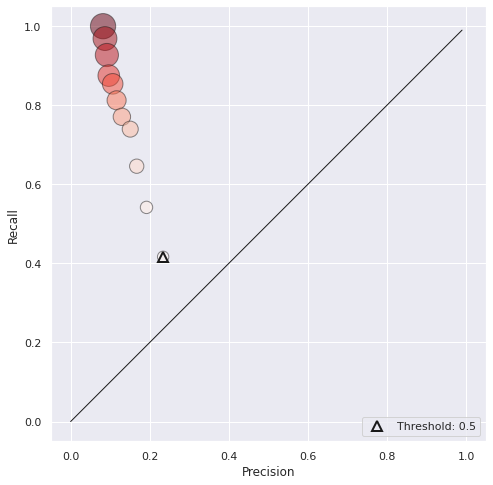

In [113]:
# Costs curve
if True:
    costs_curve(model, X, targets, chunk=100)

In [114]:
# Lowest cost


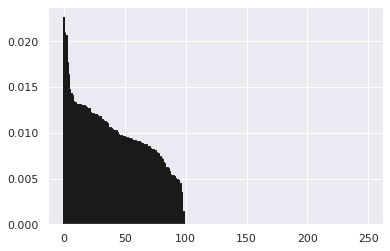

In [115]:
# Feature importances
if True:
    plot_feature_importances(model, X, 250)

In [116]:
# Feature importances: cumulated sum
if False:
    feature_importance_cumsum(model, X)

In [117]:
# Feature importances: most important ones
if False:
    plot_important_features(model, X)

In [118]:
# ROC curve
if False:
    plot_ROC_curve(model, X, targets)

# **III. Dashboard preparation**

## A. Optimisation

In [119]:
# Instanciation
model = RandomForestClassifier(random_state=0,
                               class_weight={0:ratio, 1:1})
# Guarantee a k-fold cross validation
kfold = KFold(n_splits=5)
# Create a specific cost score
cost_score = make_scorer(prediction_costs_for_cv,
                         greater_is_better=False)

### 1) GridSearchCV

In [120]:
# Set parameters range
GS_parameters = {'n_estimators':[20, 50, 100, 200],
                 'max_depth':[2, 3, 5]}
# Cross validation
rdm = GridSearchCV(model,
                   GS_parameters,
                   cv=5,
                   scoring=cost_score)
# Fit the model
rdm.fit(X_train, y_train)
# Get the best parameters combination
rdm_best = rdm.best_estimator_
# Get the lowest cost
cost = prediction_costs_for_cv(y_val, rdm_best.predict(X_val))
cost = round(cost, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [121]:
rdm_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.08523028057173107, 1: 1},
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [122]:
cost

40.31

### 2) RandomizedSearchCV

In [123]:
# Set parameters range
RS_parameters = {'n_estimators':[20, 50, 100, 200],
                 'max_depth':[2, 5, 10],
                 'max_features':[50, int(math.sqrt(X_train.shape[0])), 100],
                 'min_samples_split':[2, 5, 10],
                 'min_samples_leaf':[1, 2, 5],
                 'bootstrap':[True, False]}
# Cross validation
rdm = RandomizedSearchCV(model,
                         RS_parameters,
                         cv=5,
                         n_iter=60,
                         scoring=cost_score)
# Fit the model
rdm.fit(X_train, y_train)
# Get the best parameters combination
rdm_best = rdm.best_estimator_
# Get the lowest cost
cost = prediction_costs_for_cv(y_val, rdm_best.predict(X_val))
cost = round(cost, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [124]:
rdm_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.08523028057173107, 1: 1},
                       criterion='gini', max_depth=10, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [125]:
cost

22.18

## B. Analysis of a random sample

### 1) Static analysis

In [138]:
# Extraction of one sample from the test set
applicant_row = test_samp_df.sample(n=1)
applicant_id = applicant_row.index

# Determine if the applicant is eligible or not.
temp_df = test_samp_df.copy()
temp_df['Judgement'] = rdm_best.predict(test_samp_df)
applicant_judgement = temp_df.loc[applicant_id]['Judgement']
applicant_judgement = int(applicant_judgement)


0

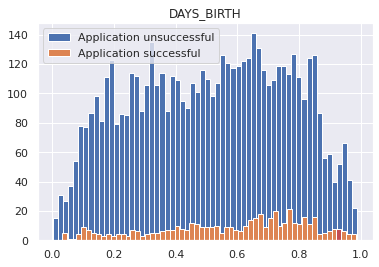

In [142]:
# Filter out the most important features
features = most_important_features(rdm_best, X, 6)
features = list(features.index)

n = 2

# POSITION OF THE APPLICANT
applicant_feature_value = applicant_row[features[n]].iloc[0]
applicant_feature_value = round(applicant_feature_value, 3)

# Distribution de la caractéristique dans le TRAIN set pour:
# - les targets à 0
# - les targets à 1
train_0_feature = list(train_samp_df[train_samp_df['TARGET']==0][features[n]])
train_1_feature = list(train_samp_df[train_samp_df['TARGET']==1][features[n]])

plt.title(features[n])
plt.hist(train_0_feature, bins=60)
n_1, bins_1, patches_1 = plt.hist(train_1_feature,
                                  bins=60)

# Special coloration for applicant identification
for i, element in enumerate(patches_1):
    if element.xy[0] > applicant_feature_value:
        n_print = i
        break
patches_1[i].set_fc('r')

plt.legend(['Application unsuccessful',
            'Application successful'])
plt.show()

### 2) Dynamic analysis